<a href="https://colab.research.google.com/github/GCioa123/PatternFlow/blob/topic-recognition/G_Chaudhari_VQVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow as tf

from tensorflow.keras.preprocessing.image import load_img

In [20]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [21]:
import os

#Loading the data

input_train_dir = 'gdrive/My Drive/keras_png_slices_data/keras_png_slices_data/keras_png_slices_train/' #this you have give your seg_train folder path
target_train_dir = 'gdrive/My Drive/keras_png_slices_data/keras_png_slices_data/keras_png_slices_seg_train/' #seg_val folder path
input_val_dir = 'gdrive/My Drive/keras_png_slices_data/keras_png_slices_data/keras_png_slices_validate/' #this you have give your seg_train folder path
target_val_dir = 'gdrive/My Drive/keras_png_slices_data/keras_png_slices_data/keras_png_slices_seg_validate/' #seg_val folder path


In [22]:
# Extract data to train and test data sets
img_size = (256, 256)
num_classes = 4
batch_size = 1

input_img_paths = sorted(
    [
        os.path.join(input_train_dir, fname)
        for fname in os.listdir(input_train_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_train_dir, fname)
        for fname in os.listdir(target_train_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

val_input_img_paths = sorted(
    [
        os.path.join(input_val_dir, fname)
        for fname in os.listdir(input_val_dir)
        if fname.endswith(".png")
    ]
)
val_target_img_paths = sorted(
    [
        os.path.join(target_val_dir, fname)
        for fname in os.listdir(target_val_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

# for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
#     print(input_path, "|", target_path)

Number of samples: 9664


In [23]:
#vectoriser

class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.beta = (
            beta  # This parameter is best kept between [0.25, 2] as per the paper.
        )

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Quantization.
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = self.beta * tf.reduce_mean(
            (tf.stop_gradient(quantized) - x) ** 2
        )
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(commitment_loss + codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices

In [24]:
#encoder 
def get_encoder(latent_dim=32):
    encoder_inputs = keras.Input(shape=(80, 80, 3))
    x = layers.Conv2D(16, 3, activation="relu", strides=2, padding="same")(
        encoder_inputs
    )
    x = layers.Conv2D(16, 3, activation="relu", strides=2, padding="same")(x)
    encoder_outputs = layers.Conv2D(latent_dim, 3, padding="same")(x)
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")


In [25]:
#decoder
def get_decoder(latent_dim=32):
    latent_inputs = keras.Input(shape=get_encoder().output.shape[1:])
    # print(latent_inputs.shape)
    x = layers.Conv2DTranspose(16,3, activation="relu", strides=2, padding="same")(
        latent_inputs
    )
    x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(3, 3, padding="same")(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [26]:
#Stand-alone VQ-VAE
def get_vqvae(latent_dim=32, num_embeddings=64):
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    inputs = keras.Input(shape=(80, 80, 3))
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return keras.Model(inputs, reconstructions, name="vq_vae")


get_vqvae().summary()


Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 80, 80, 3)]       0         
                                                                 
 encoder (Functional)        (None, 20, 20, 32)        7408      
                                                                 
 vector_quantizer (VectorQua  (None, 20, 20, 32)       2048      
 ntizer)                                                         
                                                                 
 decoder (Functional)        (None, 80, 80, 3)         7379      
                                                                 
Total params: 16,835
Trainable params: 16,835
Non-trainable params: 0
_________________________________________________________________


In [27]:
#VQ-VAE Trainer
class VQVAETrainer(keras.models.Model):
    def __init__(self, train_variance, latent_dim=32, num_embeddings=128, **kwargs):
        super(VQVAETrainer, self).__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            # og code delete - reconstructions = self.vqvae(x)
            # x = tf.expand_dims(x, axis=1)

            tmp_result = self.vqvae(x) #change tmp

            #Calculate image difference using SSIM
  
            # print(x.shape)
            # print(tf.expand_dims(x,-1).shape)
            # print(tmp_result.shape)
            #change
            # print("x",x)
            # print("o/p",tmp_result)
            

            img_diff = tf.image.ssim(x,tmp_result,1.0)
            
            # print("img",img_diff)


            # Calculate the losses. Mean squared error, change
            reconstruction_loss = (
                tf.reduce_mean((x - tmp_result) ** 2) / self.train_variance
            )
            total_loss = ( img_diff + sum(self.vqvae.losses))

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))
        #self.optimizer = tf.keras.optimizers.Adam(0.001).minimize((-1*img_diff))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss(SSIM)": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }


In [28]:

class oasis_data(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = np.array(load_img(path, target_size=self.img_size))
            x[j] = img/255
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = np.array(load_img(path, target_size=self.img_size, color_mode="grayscale"))
            # y[j] = np.expand_dims(img, 2)
            # # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            # y[j] -= 1
            one_hot = img == [0, 85, 170, 255]
            y[j] = one_hot
            
        
        #print(y)
        # return x, y
        return x


In [29]:
#train, test, split 

import random

# Split our img paths into a training and a validation set

val_samples = 1000
# random.Random(1337).shuffle(input_img_paths)
# random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:]
train_target_img_paths = target_img_paths[:]
# val_input_img_paths = input_img_paths[-val_samples:]
# val_target_img_paths = target_img_paths[-val_samples:]
val_input_img_paths = val_input_img_paths[:]
val_target_img_paths = val_target_img_paths[:]

# Instantiate data Sequences for each split
#train data
train_gen = oasis_data(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
#test data
val_gen =  oasis_data(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [30]:
print(train_gen.__len__(), val_gen.__len__())


9664 1120


In [41]:
# X_train,y_train = train_gen.__getitem__(9664)
# X_test, y_test = val_gen.__getitem__(1) .reshape(256,256,3)
X_train = np.array([tf.reshape(tf.image.resize(train_gen.__getitem__(i),[80,80]),[80,80,3]) for i in range(4500)])
#

#X_train = np.array([tf.reshape(tf.image.resize(train_gen.__getitem__(i),[28,28]),[28,28,3]) for i in range(train_gen.__len__())])
#X_test = np.array([tf.reshape(tf.image.resize(val_gen.__getitem__(i),[28,28]),[28,28,3]) for i in range(val_gen.__len__())])

X_test = np.array([tf.reshape(tf.image.resize(val_gen.__getitem__(i),[80,80]),[80,80,3]) for i in range(1000)])


# X_train = np.array([tf.image.resize(train_gen.__getitem__(i),[28,28]) for i in range(5)])


# dimension reduction to make images the same shape
# X_train = tf.expand_dims(X_train, axis=1)
# X_test = tf.expand_dims(X_test, axis=0) 

x_train_scaled = (X_train / 255.0) - 0.5
x_test_scaled = (X_test / 255.0) - 0.5

data_variance = np.var(X_train / 255.0)

print(data_variance)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


5.333676e-07


In [42]:
#tf.image.ssim(X_train[0], X_train[1],1)
print(X_train[0].shape)

(80, 80, 3)


In [43]:
# temp = X_train[0].reshape(256,256,3)
len(X_train)

4500

In [44]:
#train VQ VAE model
vqvae_trainer = VQVAETrainer(data_variance, latent_dim=32, num_embeddings=128)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
vqvae_trainer.fit(x_train_scaled, epochs=5)


Epoch 1/5
141/141 [==============================] - 201s 1s/step - loss(SSIM): 2.7561 - reconstruction_loss: 1493939.1250 - vqvae_loss: 3.2999
Epoch 2/5
141/141 [==============================] - 200s 1s/step - loss(SSIM): -0.9883 - reconstruction_loss: 1813286.7500 - vqvae_loss: 0.0021
Epoch 3/5
141/141 [==============================] - 199s 1s/step - loss(SSIM): -0.9969 - reconstruction_loss: 1831990.5000 - vqvae_loss: 1.8316e-04
Epoch 4/5
141/141 [==============================] - 199s 1s/step - loss(SSIM): -0.9974 - reconstruction_loss: 1836217.2500 - vqvae_loss: 1.4379e-04
Epoch 5/5
141/141 [==============================] - 198s 1s/step - loss(SSIM): -0.9976 - reconstruction_loss: 1839159.7500 - vqvae_loss: 1.4247e-04


In [45]:
m = get_vqvae()

In [46]:
tf.image.ssim(x_train_scaled[0],x_train_scaled[1],1)

<tf.Tensor: shape=(), dtype=float32, numpy=0.9999955>

In [47]:
x_train_scaled[0].shape

(80, 80, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


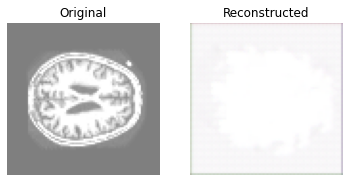

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


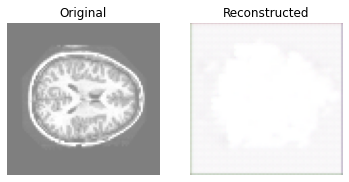

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


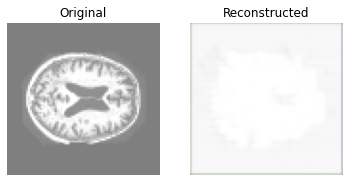

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


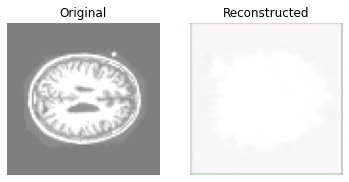

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


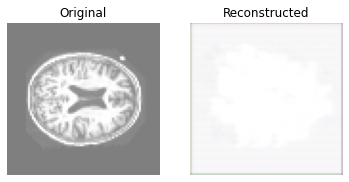

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


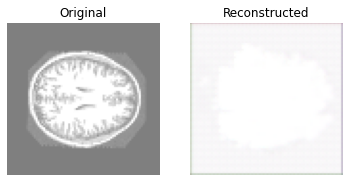

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


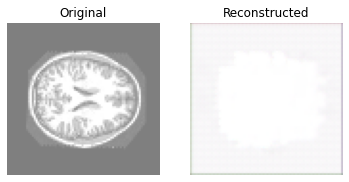

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


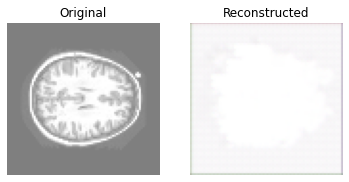

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


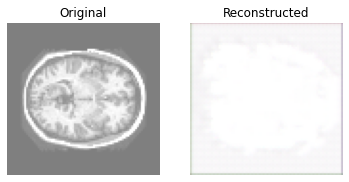

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


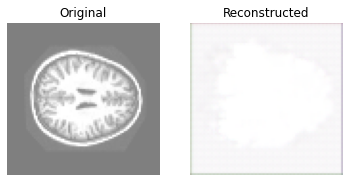

In [48]:
def show_subplot(original, reconstructed):
    plt.subplot(1, 2, 1)
    plt.imshow(original.squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.squeeze() + 0.5)
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()


trained_vqvae_model = vqvae_trainer.vqvae
idx = np.random.choice(len(X_test), 10)
test_images = X_test[idx]
reconstructions_test = trained_vqvae_model.predict(test_images)

for test_image, reconstructed_image in zip(test_images, reconstructions_test):
    show_subplot(test_image, reconstructed_image)



In [49]:

trained_vqvae_model = VQVAETrainer(data_variance, latent_dim=32, num_embeddings=128)
trained_vqvae_model.compile(optimizer=keras.optimizers.Adam())
trained_vqvae_model.fit(x_test_scaled, epochs=10)


Epoch 1/10
32/32 [==============================] - 46s 1s/step - loss(SSIM): 0.1576 - reconstruction_loss: 753935.8125 - vqvae_loss: 0.3377
Epoch 2/10
32/32 [==============================] - 44s 1s/step - loss(SSIM): 5.7554 - reconstruction_loss: 1987738.0000 - vqvae_loss: 6.7020
Epoch 3/10
32/32 [==============================] - 44s 1s/step - loss(SSIM): -0.8544 - reconstruction_loss: 1619359.5000 - vqvae_loss: 0.0463
Epoch 4/10
32/32 [==============================] - 44s 1s/step - loss(SSIM): -0.9783 - reconstruction_loss: 1845284.0000 - vqvae_loss: 0.0122
Epoch 5/10
32/32 [==============================] - 44s 1s/step - loss(SSIM): -0.9906 - reconstruction_loss: 1822847.1250 - vqvae_loss: 0.0052
Epoch 6/10
32/32 [==============================] - 44s 1s/step - loss(SSIM): -0.9933 - reconstruction_loss: 1823820.3750 - vqvae_loss: 0.0031
Epoch 7/10
32/32 [==============================] - 44s 1s/step - loss(SSIM): -0.9947 - reconstruction_loss: 1827195.0000 - vqvae_loss: 0.0020
Ep